In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import os
import pickle
import pandas as pd
from skimage.transform import resize
from PIL import Image
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform

**Load data**

In [2]:
image_dir='C:\\Users\\user\\Documents\\Documents\\McGill Undergrad\\Year 3\\semester 2\\Comp 551\\proj4\\data\\data\\allendata'
dir_list=os.listdir(image_dir)

In [3]:
filename='C:\\Users\\user\\Documents\\Documents\\McGill Undergrad\\Year 3\\semester 2\\Comp 551\\proj4\\data\\data\\GO_terms.pkl'
with open(filename, 'rb') as handle:
    GO_data=pickle.load(handle)

In [19]:
with open('GO_terms_per_gene.csv', 'w') as f:
    for key in GO_data.keys():
        f.write("%s,%s\n"%(key,GO_data[key]))

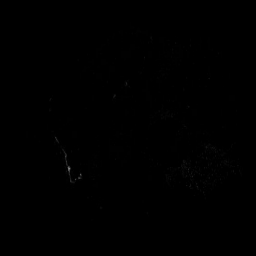

In [20]:
#check how the process looks for one image
gene_id = dir_list[1]
GO_terms=GO_data[str(gene_id)]
gene_dir=image_dir+'\\'+gene_id+'\\'
jpg_file = os.listdir(gene_dir)[0]
jpg_array=np.asarray(Image.open(gene_dir+jpg_file).convert('L')) #keep all colours
img=resize(jpg_array, (256,256), anti_aliasing=True, mode='constant') #resize all images to 140x300
img=img*255 #multiply by 255 to scale images back to the same integer value distribution
img=np.asarray(img, dtype='uint8')
img = Image.fromarray(img)
img

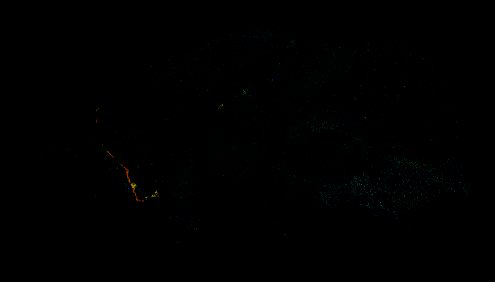

In [21]:
Image.open(gene_dir+jpg_file)

In [29]:
#use i to control how many samples are processed
i=0
j=0
data_list=[]
GO_list = []
for gene_id in dir_list:
    try:
        GO_terms=GO_data[str(gene_id)]
        gene_dir=image_dir+'\\'+gene_id+'\\'
        jpg_files=os.listdir(gene_dir)
        for jpg_file in jpg_files:
            jpg_array=np.asarray(Image.open(gene_dir+jpg_file).convert('L')) #converts it to black and white?
            img=resize(jpg_array, (64,64), anti_aliasing=True, mode='constant') #resize all images to 140x300
            img=img*255 #multiply by 255 to scale images back to the same integer value distribution
            img=np.asarray(img, dtype='uint8')
            img = Image.fromarray(img) #convert it back to an image from array, for input into Comb_dataset
            data_list.append(img)
            GO_list.append(GO_terms)
    except:
        continue
    i+=1
    if i%500==0:
        break

In [30]:
len(data_list)

555

In [31]:
filename='data.pkl'
with open(filename, 'wb') as handle:
    pickle.dump(data_list, handle)
pkl_path='C:\\Users\\user\\Documents\\Documents\\McGill Undergrad\\Year 3\\semester 2\\Comp 551\\proj4\\data\\data\\data.pkl'

In [32]:
with open('GO_terms_per_image.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(GO_list)

csvFile.close()
csv_path = 'C:\\Users\\user\\Documents\\Documents\\McGill Undergrad\\Year 3\\semester 2\\Comp 551\\proj4\\data\\data\\GO_terms_per_image.csv'

**GAN**

In [48]:
import argparse
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image
import torchvision.utils as vutils
from torch.utils.data import DataLoader

In [34]:
batch_size = 100
nc = 1 #number of channels (3 for RGB)
nz = 300 #size of latent vector
ngf = 256 #size of feature maps in generator
ndf = 256 #size of feature maps in discriminator
num_epochs = 5
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [35]:
class Comb_Dataset(Dataset):

    def __init__(self, csv_file, pickle_path, transform=None):
        self.images = pd.read_pickle(pickle_path)
        self.transform = transform
        self.labels = pd.read_csv(csv_file, sep='\t', header=None)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        labels = self.labels.iloc[idx,0]
        sample = {'image': image, 'label': labels}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [36]:
dataset = Comb_Dataset(csv_path, pickle_path =pkl_path)

GO:0003674,GO:0005575


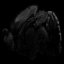

In [37]:
img_idx = 309
print(dataset[img_idx]["label"])
dataset[img_idx]["image"]

In [38]:
class ToTensor(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        transformed_image = transforms.ToTensor()
        return {'image': transformed_image(image)} 
               # 'label': torch.tensor(label)}

In [39]:
transformed_data = Comb_Dataset(csv_file = csv_path, pickle_path = pkl_path, 
                                transform = ToTensor()) 

In [40]:
data_loader = torch.utils.data.DataLoader(transformed_data, batch_size=batch_size, shuffle=True)

In [41]:
#weights are initialized from a Normal distribution with mean=0, stdev=0.2
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [42]:
#start by creating low resolution image, then progressively get more complex
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [43]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 256 x 256
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # output 256*2
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)\
    

In [44]:
# Loss functions
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Initialize weights
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(2048, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [45]:
# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(256, nz, 1, 1)
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))

In [49]:
# Training Loop
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(data_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator.zero_grad()
        # Format batch
        real_cpu = data['image'].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = adversarial_loss(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = adversarial_loss(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = adversarial_loss(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(data_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/6]	Loss_D: 0.0429	Loss_G: 50.3079	D(x): 0.9609	D(G(z)): 0.0000 / 0.0000
[1/5][0/6]	Loss_D: 27.6311	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[2/5][0/6]	Loss_D: 27.6310	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[3/5][0/6]	Loss_D: 27.6311	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000
[4/5][0/6]	Loss_D: 27.6311	Loss_G: 0.0000	D(x): 1.0000	D(G(z)): 1.0000 / 1.0000


In [ ]:
#try rectangular GAN
#try convert back to grayscale

In [ ]:
#the first input should be the dimension of image but is instead the batch size

In [ ]:
for i, data in enumerate(data_loader, 300):
    print(data['image'])
    print(i)

In [ ]:
print(i) #so there are four tensors...

In [ ]:
print(data['image'].size())

In [ ]:
print(data['image'][0])

In [ ]:
class ToTensor(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        #transformed_image = torch.from_numpy(image).double()
        transformed_image = transforms.ToTensor()
        unsqueezed_image = torch.unsqueeze(transformed_image(image),0) #add a dimension with value 1 to represent colour
        return {'image': unsqueezed_image} 
               # 'label': torch.tensor(label)}
dataset[img_idx]["image"]

In [ ]:
im1 = dataset[1046]['image']

In [ ]:
transformed_image= transforms.ToTensor()
transformed_image(im1).size()

In [ ]:
im1.mode